In [1]:
import numpy as np
import math

In [45]:
class Scheduler:
    def __init__(self, pareto_a=5.5, pareto_m=500, time_between_clients=11, 
                 initial_clients_count=10, generated_clients_count=1000):
        self.pareto_a = pareto_a
        self.pareto_m = pareto_m

        self.time_between_clients = time_between_clients

        A_mean = (pareto_m * pareto_a / (pareto_a - 1))
        A_std = math.sqrt((pareto_a / (pareto_a-2)) * (pareto_m / (pareto_a - 1)) ** 2)
        A = A_mean + A_std

        time_between_clients_mean = time_between_clients
        time_between_clients_std = math.sqrt(time_between_clients)
        λ = 1 / (time_between_clients_mean - time_between_clients_std)
        self.r = (λ * A)

        self.initial_clients_count = initial_clients_count
        self.generated_clients_count = generated_clients_count

        self.processed_clients = []
        self.all_clients = []

        self.queue = []
        self.t = 0
    
    def clean(self):
        self.processed_clients = []
        self.all_clients = []

        self.queue = []
        self.t = 0
    
    def generate_initial_clients(self):
        for i in range(self.initial_clients_count):
            Ak = int((np.random.pareto(self.pareto_a) + 1) * self.pareto_m)
            rk_mean = int(np.random.uniform(self.r / 5.5, self.r * (10 / 5.5)))
            Rk = int(np.random.uniform(0, Ak))
            Tk0 = 0
            client = [Tk0, Ak, Rk, rk_mean]
            self.queue.append(client)
        
    def generate_clients(self):
        T0 = 0
        for i in range(self.generated_clients_count):
            Ak = int((np.random.pareto(self.pareto_a) + 1) * self.pareto_m)
            rk_mean = int(np.random.uniform(self.r / 5.5, self.r * (10 / 5.5)))
            T0 += int(np.random.exponential(self.time_between_clients))
            Rk = 0
            client = [T0, Ak, Rk, rk_mean]
            self.all_clients.append(client)
    
    def index_client(self, index_strategy, rk, Rk, rk_mean, Tk, Tk0):
        if index_strategy == "IBM":
            return rk
        elif index_strategy == "RoundRobin":
            return -Tk0
        elif index_strategy == "Google":
            return rk * Tk / Rk
        elif index_strategy == "Huawei":
            return rk / Rk
        elif index_strategy == "TAS":
            return rk / (Tk + 1e-20) 
        elif index_strategy == "T":
            c1 = 0.6 / math.log(13/7)
            return Rk / (  Tk + (Rk / (c1*rk_mean + 1e-20))  )
        elif index_strategy == "Random":
            return np.random.uniform(0, 1)
        
    def generate_random_strategy(self, strategies_list, probabilities_list):
        return np.random.choice(strategies_list, p=probabilities_list)

    def run_simulation(self, strategies_list, probabilities_list):
        history = []
        huawei_quality_metric = 0.
        
        while len(self.all_clients) != 0:
            self.t += 1
            strategy = self.generate_random_strategy(strategies_list, probabilities_list)

            j = 0
            while ((j < len(self.all_clients)) and (self.all_clients[j][0] <= self.t)):
                j += 1
            self.queue += self.all_clients[:j]
            self.all_clients[:j] = []

            max_index = -1e20
            argmax_index = 0
            rk_argmax = 0
            for k in range(len(self.queue)):
                Tk0 = self.queue[k][0]
                Tk = self.t - Tk0
                rk_mean = self.queue[k][3]
                rk = int(np.random.uniform(rk_mean * 0.7, rk_mean * 1.3))
                Rk = self.queue[k][2] + 1e-10
                
                index_k = self.index_client(strategy, rk, Rk, rk_mean, Tk, Tk0)
                if index_k > max_index :
                    max_index = index_k
                    argmax_index = k
                    rk_argmax = rk

            if len(self.queue) > 0:
                self.queue[argmax_index][2] += rk_argmax
                if self.queue[argmax_index][2] >= self.queue[argmax_index][1]:
                    self.queue[argmax_index].append(self.t - self.queue[argmax_index][0])
                    self.processed_clients.append(self.queue[argmax_index])
                    del self.queue[argmax_index]
            history.append(len(self.queue))
            
        for i in range(len(self.processed_clients)):
            huawei_quality_metric += self.processed_clients[i][1] / self.processed_clients[i][-1]
        huawei_quality_metric /= len(self.processed_clients)
        
        return history, huawei_quality_metric

In [103]:
for critery in ["IBM", "RoundRobin", "Google", "Huawei", "TAS", "T", "Random"]:
    metrics = []
    for i in range(10):
        scheduler = Scheduler()
        scheduler.generate_initial_clients()
        scheduler.generate_clients()
        history, metric = scheduler.run_simulation([critery], [1])
        metrics.append(metric)
    print(critery, ":", sum(metrics)/len(metrics))

IBM : 87.39031995645766
RoundRobin : 26.377272178636343
Google : 37.27888731551354
Huawei : 62.365521123161685
TAS : 81.04517448171491
T : 86.23771914618456
Random : 26.616087846207165


In [115]:
scheduler = Scheduler()
scheduler.generate_initial_clients()
scheduler.generate_clients()
strategies = ["IBM", "T", "TAS"]

X, Y, z, z_high, z_low = [], [], [], [], []
for i in range(10):
    x = (i + 1) / 10
    X.append(x)
    Y = []
    for h in range(9-i):
        y = (h + 1) / 10
        Y.append(y)
        print(x, y)
        metrics = []
        for j in range(5):
            history, metric = scheduler.run_simulation(strategies, [x, y, 1-(x+y)])
            scheduler.clean()
            scheduler.generate_initial_clients()
            scheduler.generate_clients()
            metrics.append(metric)
        metrics = np.array(metrics)

        metric_mean = np.mean(metrics)
        metric_high = np.mean(metrics) + np.std(metrics)
        metric_low = np.mean(metrics) - np.std(metrics)

        z.append(metric_mean)
        z_high.append(metric_high)
        z_low.append(metric_low)
    for h in range(4-i, 5):
        y = (h + 1) / 10
        Y.append(y)
        z.append(80)
        z_high.append(0)
        z_low.append(0)

0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.4 0.1
0.4 0.2
0.4 0.3
0.4 0.4
0.4 0.5
0.4 0.6
0.5 0.1
0.5 0.2
0.5 0.3
0.5 0.4
0.5 0.5
0.6 0.1
0.6 0.2
0.6 0.3
0.6 0.4
0.7 0.1
0.7 0.2
0.7 0.3
0.8 0.1
0.8 0.2
0.9 0.1


In [116]:
Y = np.array(Y) + 0.5

In [117]:
x = 0.1
y = 0.1
history, metric = scheduler.run_simulation(strategies, [x, y, 1-(x+y)])
scheduler.clean()
scheduler.generate_initial_clients()
scheduler.generate_clients()
print(metric)

print(np.array(z).reshape(10, 10))
X_, Y_ = np.meshgrid(X, Y)
print(X_)
print(Y_)

82.9244458554921
[[ 82.0602748   81.9687449   83.08230961  82.80853227  85.11747378
   85.1044683   84.81784123  84.02928128  85.30798582  80.        ]
 [ 80.31205641  83.25245302  81.78379603  83.5978719   84.64978431
   86.43171345  85.31294912  86.72637441  80.          80.        ]
 [ 81.49764349  84.36925886  83.97412624  83.14049686  85.08104473
   85.64761736  84.14416557  80.          80.          80.        ]
 [ 83.73372687  83.022516    83.95726839  84.90134507  83.95779073
   86.68567357  80.          80.          80.          80.        ]
 [ 83.19285931  84.02397439  85.84227071  85.84213915  86.38395485  80.
   80.          80.          80.          80.        ]
 [ 84.87860004  84.52557935  85.6923281   86.07483253  80.          80.
   80.          80.          80.          80.        ]
 [ 85.17884861  86.1606406   86.53019866  80.          80.          80.
   80.          80.          80.          80.        ]
 [ 85.81037927  86.94886081  80.          80.          80.    

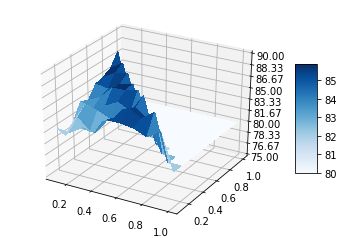

In [138]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X_, Y_, np.array(z).reshape(10, 10), cmap=cm.Blues,
                       linewidth=0, antialiased=False)

ax.set_zlim(75, 90)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

In [139]:
np.max(np.array(z)), np.matrix.argmax(np.matrix(np.array(z).reshape(10, 10)))

(87.596190164412889, 80)